In [1]:
# coding:utf-8
import findspark
findspark.init("/opt/cloudera/parcels/CDH-6.3.1-1.cdh6.3.1.p0.1470567/lib/spark","/usr/bin/python2.7")

import os
os.environ["JAVA_HOME"] = "/usr/java/jdk1.8.0_181-cloudera"

from pyspark.sql import functions as F
from pyspark import SparkContext
from pyspark.sql import SparkSession,HiveContext,Window
from pyspark.sql.types import IntegerType, FloatType, DoubleType, ArrayType, StringType, DecimalType
from pyspark.sql.functions import *
from pyspark.sql.types import *
import datetime
import sys
import pandas as pd
import numpy as np

spark_session = SparkSession.builder.enableHiveSupport().appName("hhh2") \
    .config("spark.driver.memory","30g") \
    .config("spark.pyspark.driver.python","/usr/bin/python2.7")\
    .config("spark.pyspark.python","/usr/bin/python2.7") \
    .config("spark.yarn.executor.memoryOverhead","20G") \
    .config("spark.sql.broadcastTimeout", "3600")\
    .getOrCreate()
hc = HiveContext(spark_session.sparkContext)

##### 不同阶段战败用户的战败原因

In [ ]:
'''
select 
    a.level, fail_reason_level_1, count(distinct a.mobile) as vol
from dw_mg_fail_population_split a
left join 
(
    SELECT mobile, fail_reason_level_1
    FROM marketing_modeling.app_failed_reason
    LATERAL VIEW explode(fail_reason_fir_level) a AS fail_reason_level_1
)b
on a.mobile = b.mobile;


select 
    a.level, fail_reason_level_2, count(distinct a.mobile) as vol
from dw_mg_fail_population_split a
left join 
(
    SELECT mobile, fail_reason_level_2
    FROM marketing_modeling.app_failed_reason
    LATERAL VIEW explode(fail_reason_sec_level) a AS fail_reason_level_2
)b
on a.mobile = b.mobile;
'''

##### 不同车系的战败原因时间变化趋势

In [2]:
fail_df = hc.sql('''
select 
    a.mobile, 
    b.fail_reason_fir_level as level_1, 
    b.fail_reason_sec_level as level_2, 
    a.level
from dw_mg_fail_population_split a
left join marketing_modeling.app_failed_reason b
on a.mobile = b.mobile
''').toPandas()

fail_df 

,mobile,level_1,level_2,level
0,13001365322,[u'\u5df2\u8d2d\u8f66'],[],1
1,13001435777,[u'\u6682\u4e0d\u4e70\u8f66'],[],1
2,13001486825,[u'\u7ecf\u9500\u5546\u5730\u7406\u4f4d\u7f6e\...,[],3
3,13001542169,[u'\u65e0\u8d2d\u8f66\u9700\u6c42'],[u'\u4e0d\u4e70\u8f66'],1
4,13001791022,[u'\u65e0\u8d2d\u8f66\u9700\u6c42'],[u'\u4e0d\u4e70\u8f66'],1
...,...,...,...,...
819136,19999751188,[u'\u7ecf\u9500\u5546\u5730\u7406\u4f4d\u7f6e\...,[],1
819137,19999774882,[],[],1
819138,19999999807,"[u'\u5df2\u8d2d\u8f66', u'\u65e0\u8d2d\u8f66\u...",[u'\u4e0d\u4e70\u8f66'],1
819139,19999999810,"[u'\u5df2\u8d2d\u8f66', u'\u65e0\u8d2d\u8f66\u...",[u'\u4e0d\u4e70\u8f66'],1


In [3]:
fail_df['level_1_list'] = fail_df['level_1'].apply(lambda x: x[1:-1].replace("u'", "").replace("'", "").split(', '))
fail_df

,mobile,level_1,level_2,level,level_1_list
0,13001365322,[u'\u5df2\u8d2d\u8f66'],[],1,[\u5df2\u8d2d\u8f66]
1,13001435777,[u'\u6682\u4e0d\u4e70\u8f66'],[],1,[\u6682\u4e0d\u4e70\u8f66]
2,13001486825,[u'\u7ecf\u9500\u5546\u5730\u7406\u4f4d\u7f6e\...,[],3,[\u7ecf\u9500\u5546\u5730\u7406\u4f4d\u7f6e\u4...
3,13001542169,[u'\u65e0\u8d2d\u8f66\u9700\u6c42'],[u'\u4e0d\u4e70\u8f66'],1,[\u65e0\u8d2d\u8f66\u9700\u6c42]
4,13001791022,[u'\u65e0\u8d2d\u8f66\u9700\u6c42'],[u'\u4e0d\u4e70\u8f66'],1,[\u65e0\u8d2d\u8f66\u9700\u6c42]
...,...,...,...,...,...
819136,19999751188,[u'\u7ecf\u9500\u5546\u5730\u7406\u4f4d\u7f6e\...,[],1,[\u7ecf\u9500\u5546\u5730\u7406\u4f4d\u7f6e\u4...
819137,19999774882,[],[],1,[]
819138,19999999807,"[u'\u5df2\u8d2d\u8f66', u'\u65e0\u8d2d\u8f66\u...",[u'\u4e0d\u4e70\u8f66'],1,"[\u5df2\u8d2d\u8f66, \u65e0\u8d2d\u8f66\u9700\..."
819139,19999999810,"[u'\u5df2\u8d2d\u8f66', u'\u65e0\u8d2d\u8f66\u...",[u'\u4e0d\u4e70\u8f66'],1,"[\u5df2\u8d2d\u8f66, \u65e0\u8d2d\u8f66\u9700\..."


In [4]:
sereis_lst_original = [k for k in list(set([i for sub in list(fail_df['level_1_list']) for i in sub])) if k != '']
sereis_lst_original

['\\u76f8\\u5173\\u4e1a\\u52a1\\u54a8\\u8be2',
 '\\u65e0\\u6cd5\\u8054\\u7cfb',
 '\\u4fe1\\u606f\\u88ab\\u76d7\\u91cd\\u590d\\u7ebf\\u7d22',
 '\\u65e0\\u8d2d\\u8f66\\u8d44\\u8d28',
 '\\u5382\\u5bb6\\u6d4b\\u8bd5\\u62bd\\u67e5',
 '\\u4e8c\\u7f51',
 '\\u65e0\\u8d2d\\u8f66\\u9700\\u6c42',
 '\\u7ade\\u54c1\\u610f\\u5411\\u5ba2\\u6237',
 '\\u8d44\\u91d1\\u95ee\\u9898',
 '\\u8d2d\\u8f66\\u504f\\u597d\\u95ee\\u9898',
 '\\u7ecf\\u9500\\u5546\\u5730\\u7406\\u4f4d\\u7f6e\\u4e0d\\u5408\\u9002',
 '\\u62d2\\u7edd\\u6c9f\\u901a',
 '\\u5df2\\u8d2d\\u8f66',
 '\\u7ade\\u4e89\\u5bf9\\u624b\\u63a2\\u6d4b',
 '\\u5237\\u5355',
 '\\u65e0\\u73b0\\u8f66',
 '\\u9700\\u6c42\\u4e0d\\u5339\\u914d',
 '\\u6682\\u4e0d\\u4e70\\u8f66',
 '\\u5bb6\\u4eba\\u670b\\u53cb\\u53cd\\u5bf9']

In [6]:
oppor_df = hc.sql("""select 
    phone, 
    series_chinese_name, 
    behavior_time
from 
(
    select phone, series_id, behavior_time
    from 
    (    
        select 
            phone, 
            series_id,
            behavior_time,
            row_number() over(partition by phone order by behavior_time) as row_num
        from marketing_modeling.dw_oppor_behavior
        where brand_id = '121'
    ) a 
    where row_num = 1
) aa 
join
(
    select series_id, series_chinese_name
    from dtwarehouse.cdm_dim_series 
    where series_chinese_name in ('MG6',
                                'MGZS',
                                '全新MG5',
                                'MGHS',
                                'MG领航',
                                'MGZS纯电动',
                                'MG3',
                                'eMG6',
                                'eMGHS',
                                'MG5',
                                '锐腾',
                                'MGGT')
) bb 
on aa.series_id = bb.series_id""").toPandas()
oppor_df

,phone,series_chinese_name,behavior_time
0,10216028446,MG3,2019-07-30 22:42:43
1,11058040788,MG6,2020-09-10 11:00:22
2,11233445667,MGHS,2020-10-11 09:45:52
3,11377182713,MGZS,2020-12-31 11:42:51
4,11914909104,MG6,2020-12-29 11:34:46
...,...,...,...
2250157,19994559397,MG6,2020-08-22 18:24:23
2250158,19995491379,全新MG5,2021-04-29 12:41:28
2250159,19995862533,MG6,2020-09-13 10:57:52
2250160,19997675764,全新MG5,2021-02-26 08:58:29


In [8]:
from datetime import datetime
oppor_df['behavior_datetime'] = oppor_df['behavior_time'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
oppor_df['behavior_month'] = oppor_df['behavior_datetime'].apply(lambda x: datetime(x.year, x.month, 1))
oppor_df.head()

,phone,series_chinese_name,behavior_time,behavior_datetime,behavior_month
0,10216028446,MG3,2019-07-30 22:42:43,2019-07-30 22:42:43,2019-07-01
1,11058040788,MG6,2020-09-10 11:00:22,2020-09-10 11:00:22,2020-09-01
2,11233445667,MGHS,2020-10-11 09:45:52,2020-10-11 09:45:52,2020-10-01
3,11377182713,MGZS,2020-12-31 11:42:51,2020-12-31 11:42:51,2020-12-01
4,11914909104,MG6,2020-12-29 11:34:46,2020-12-29 11:34:46,2020-12-01


In [77]:
import seaborn as sns
import matplotlib.pyplot as plt
# plt.rcParams['font.sans-serif'] =  ['SimHei']
# sns.set(font='SimHei')

In [87]:
fail_chinese = """相关业务咨询
无法联系
信息被盗重复线索
无购车资质
厂家测试抽查
二网
无购车需求
竞品意向客户
资金问题
购车偏好问题
经销商地理位置不合适
拒绝沟通
已购车
竞争对手探测
刷单
无现车
需求不匹配
暂不买车
家人朋友反对""".split('\n')

/app/anaconda3/envs/python37_smcsandbox/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 32431 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/app/anaconda3/envs/python37_smcsandbox/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 30005 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/app/anaconda3/envs/python37_smcsandbox/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 21160 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/app/anaconda3/envs/python37_smcsandbox/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 38160 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/app/anaconda3/envs/python37_smcsandbox/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 33150 missing from current font.
  font.set_text(s, 0.0, flags=flags)


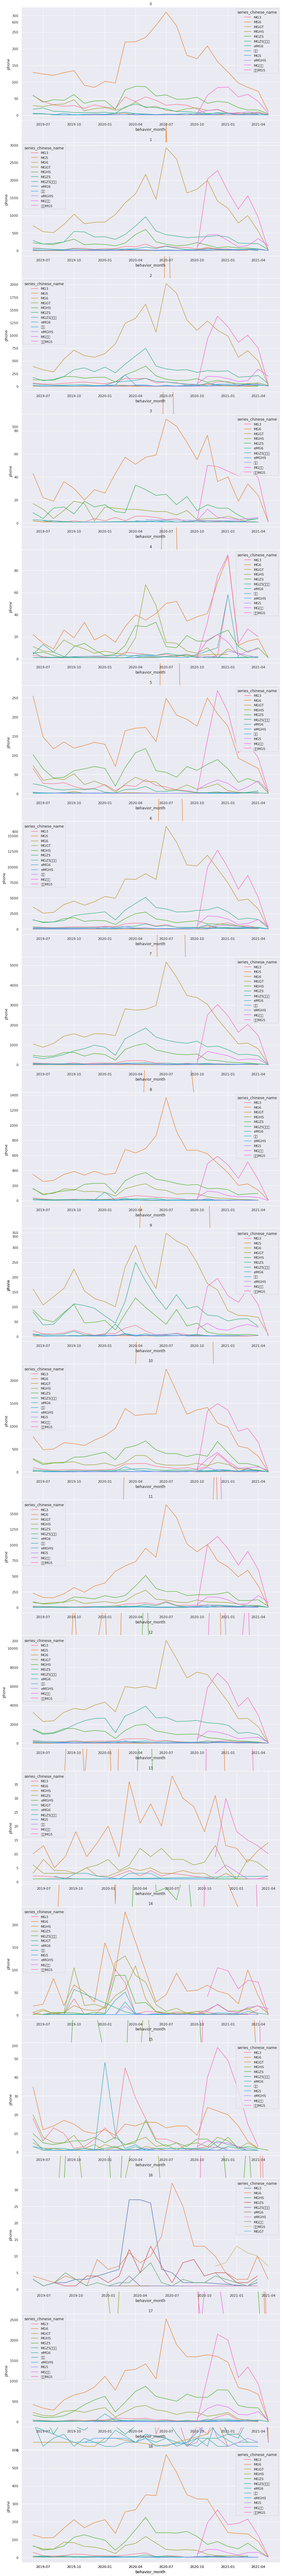

In [79]:
n = len(sereis_lst_original)
fig = plt.figure(figsize=(15,8*n))
sns.lineplot(x='behavior_month', y='phone', hue='series_chinese_name', data = series_df)

for i in range(n):
    cur_series = sereis_lst_original[i]
    cur_mobile_lst = list(fail_df[fail_df['level_1_list'].apply(lambda x: True if cur_series in x else False)]['mobile'])
    cur_oppor_df = oppor_df[oppor_df['phone'].isin([str(i) for i in cur_mobile_lst])]
    series_df = cur_oppor_df.groupby(by=['behavior_month', 'series_chinese_name']).agg({'phone': 'count'}).reset_index()

#     series_df
    ax = fig.add_subplot(n, 1,i+1)
    plt.title(str(i))
    sns.lineplot(x='behavior_month', y='phone', hue='series_chinese_name', data = series_df)
    

In [88]:
import numpy as np

n = len(sereis_lst_original)

stacked_df = pd.DataFrame()

for i in range(n):
    cur_series = sereis_lst_original[i]
    cur_mobile_lst = list(fail_df[fail_df['level_1_list'].apply(lambda x: True if cur_series in x else False)]['mobile'])
    cur_oppor_df = oppor_df[oppor_df['phone'].isin([str(i) for i in cur_mobile_lst])]
    series_df = cur_oppor_df.groupby(by=['behavior_month', 'series_chinese_name']).agg({'phone': 'count'}).reset_index()

    series_df['percentage'] = series_df['phone'] / np.sum(series_df['phone'])
    series_df['fail_reason'] = fail_chinese[i]
    
    stacked_df = pd.concat([stacked_df, series_df], axis=0)

In [90]:
stacked_df.to_csv('seriesXmonthXfail_reason.csv', index='False')